In [1]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

file_path = "../data/pokemon/"

file_combats = "combats.csv"
file_pokemon = "pokemon.csv"
file_tests = "tests.csv"

pokemon = pd.read_csv(file_path + file_pokemon)

In [2]:
combats = pd.read_csv(file_path + file_combats)

In [3]:
combats.head(20)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
5,657,752,657
6,192,134,134
7,73,545,545
8,220,763,763
9,302,31,31


In [4]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
#             800 non-null int64
Name          799 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 69.6+ KB


In [5]:
pokemon.head(10)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False
9,10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False


In [6]:
types_list = []
for i in pokemon["Type 1"].unique():
    types_list.append(i)
for i in pokemon["Type 2"].unique():
    if i not in types_list:
        types_list.append(i)

In [7]:
types_list = [x for x in types_list if type(x) == str]
for i in types_list:
    print("binary_"+i)

binary_Grass
binary_Fire
binary_Water
binary_Bug
binary_Normal
binary_Poison
binary_Electric
binary_Ground
binary_Fairy
binary_Fighting
binary_Psychic
binary_Rock
binary_Ghost
binary_Ice
binary_Dragon
binary_Dark
binary_Steel
binary_Flying


In [8]:
def create_typeBinaries(data,types,cols):
    for ptype in types:
        data[str("binary_"+ptype)] = [1 if (ptype in [data[str(y)][i] for y in cols]) else 0 for i in range(len(data[cols[0]]))]
    return(data)

In [9]:
pokemon = create_typeBinaries(pokemon,types_list,["Type 1","Type 2"])

In [10]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'binary_Grass',
       'binary_Fire', 'binary_Water', 'binary_Bug', 'binary_Normal',
       'binary_Poison', 'binary_Electric', 'binary_Ground', 'binary_Fairy',
       'binary_Fighting', 'binary_Psychic', 'binary_Rock', 'binary_Ghost',
       'binary_Ice', 'binary_Dragon', 'binary_Dark', 'binary_Steel',
       'binary_Flying'],
      dtype='object')

In [11]:
def create_generationBinaries(data,columns):
    for column in columns:
        for unique_value in data[column].unique():
            data[str(str(column)+str(unique_value))] = [1 if data[column][i] == unique_value else 0 for i in range(len(data[column]))]
    return(data)

In [12]:
pokemon = create_generationBinaries(pokemon,["Generation"])

In [ ]:
#Data Exploration

In [13]:
def myUnique(data_column):
    temp = []
    for i in data_column:
        if i not in temp:
            temp.append(i)
    return(temp)

In [ ]:
def getBattles(mydata,columns=["Type 1","Type 2"]):
    battles = []
    for i in mydata.index:
        temp = [mydata[columns[0]][i],mydata[columns[1]][i]]
        temp.sort()
        battles.append(''.join(temp))
    mydata["Battles"] = battles
    return(mydata)

In [14]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'binary_Grass',
       'binary_Fire', 'binary_Water', 'binary_Bug', 'binary_Normal',
       'binary_Poison', 'binary_Electric', 'binary_Ground', 'binary_Fairy',
       'binary_Fighting', 'binary_Psychic', 'binary_Rock', 'binary_Ghost',
       'binary_Ice', 'binary_Dragon', 'binary_Dark', 'binary_Steel',
       'binary_Flying', 'Generation1', 'Generation2', 'Generation3',
       'Generation4', 'Generation5', 'Generation6'],
      dtype='object')

In [15]:
pokemon["Legendary"] = [1 if x == True else 0 for x in pokemon["Legendary"]]

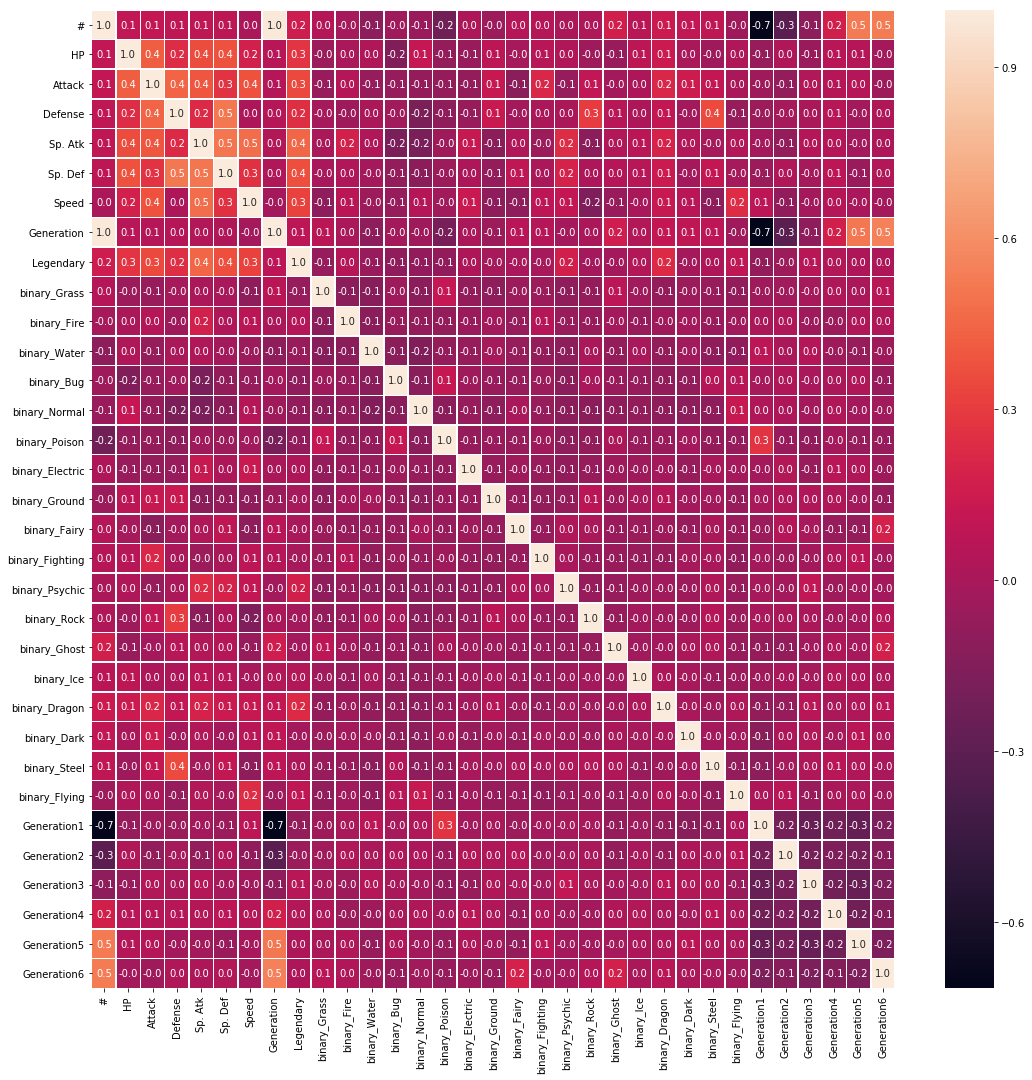

In [16]:
f,ax = plt.subplots(figsize=(18,18))
sns.heatmap(pokemon.corr(), annot=True,linewidths=.5,fmt='.1f',ax=ax)

In [17]:
def getDifferences(first_pokemon,second_pokemon,winner,mydata,num_columns):
    temp = pd.dataframe()
    if first_pokemon == winner:
        loser = second_pokemon
    else:
        loser = first_pokemon
    for i in num_columns:
        temp[i] = mydata[i][winner] - mydata[i][loser]
    return(temp)

def getBinaries(mydata,column,prefix):
    for i in np.unique(mydata[column]):
        mydata[str(prefix+i)] = [1 if x == i else 0 for x in mydata[column]]
    return(mydata)
        

In [18]:
binaries = [x for x in pokemon.columns if "binary" in str(x) or "Generation" in str(x)] + ["Legendary"]

In [19]:
binaries

['Generation',
 'binary_Grass',
 'binary_Fire',
 'binary_Water',
 'binary_Bug',
 'binary_Normal',
 'binary_Poison',
 'binary_Electric',
 'binary_Ground',
 'binary_Fairy',
 'binary_Fighting',
 'binary_Psychic',
 'binary_Rock',
 'binary_Ghost',
 'binary_Ice',
 'binary_Dragon',
 'binary_Dark',
 'binary_Steel',
 'binary_Flying',
 'Generation1',
 'Generation2',
 'Generation3',
 'Generation4',
 'Generation5',
 'Generation6',
 'Legendary']

In [20]:
num_columns = ["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]

In [40]:
pokemon.iloc[:5,:]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,binary_Dragon,binary_Dark,binary_Steel,binary_Flying,Generation1,Generation2,Generation3,Generation4,Generation5,Generation6
0,1,Bulbasaur,Grass,Poison,0.172549,0.231579,0.191304,0.283505,0.195652,0.222222,...,0,0,0,0,1,0,0,0,0,0
1,2,Ivysaur,Grass,Poison,0.231373,0.300000,0.252174,0.360825,0.260870,0.305556,...,0,0,0,0,1,0,0,0,0,0
2,3,Venusaur,Grass,Poison,0.309804,0.405263,0.339130,0.463918,0.347826,0.416667,...,0,0,0,0,1,0,0,0,0,0
3,4,Mega Venusaur,Grass,Poison,0.309804,0.500000,0.513043,0.577320,0.434783,0.416667,...,0,0,0,0,1,0,0,0,0,0
4,5,Charmander,Fire,NaN,0.149020,0.247368,0.165217,0.257732,0.130435,0.333333,...,0,0,0,0,1,0,0,0,0,0


In [67]:
def getFinalForm(combats,pokemon,binaries,num_columns):
    final = pd.DataFrame()
    final["Y"] = [1 if combats["First_pokemon"][x] == combats["Winner"][x] else 0 for x in range(len(combats))]
    final["first ID"] = combats["First_pokemon"]
    final["second ID"] = combats["Second_pokemon"]
    
    #final["winner ID"] = [combats["First_pokemon"][x] if combats["First_pokemon"][x] == combats["Winner"][x] else combats["Second_pokemon"][x] for x in range(len(combats))]
    #final["loser ID"] = [combats["Second_pokemon"][x] if combats["First_pokemon"][x] == combats["Winner"][x] else combats["First_pokemon"][x] for x in range(len(combats))]
    
    #final = final.iloc[:100,:]
    
    # for the winner, add the relevant binaries (Generation, Legendary, Types)
    for biny in binaries:
        final[str("first_" + biny)] = [int(pokemon.loc[pokemon["#"] == pok_id,biny]) for pok_id in final["first ID"]]
        final[str("second_" + biny)] = [int(pokemon.loc[pokemon["#"] == pok_id,biny]) for pok_id in final["second ID"]]
    
    for num_col in num_columns:
        #final[str("winner"+num_col+"_adv")] = [int(pokemon.loc[pokemon["#"] == final["winner ID"][i],num_col]) - int(pokemon.loc[pokemon["#"] == final["loser ID"][i],num_col]) for i in range(len(final["winner ID"]))]
        final[str("first_"+num_col)] = [(pokemon.loc[pokemon["#"] == final["first ID"][i],num_col]).item() for i in range(len(final["first ID"]))]
        final[str("second_"+num_col)] = [(pokemon.loc[pokemon["#"] == final["second ID"][i],num_col]).item() for i in range(len(final["second ID"]))]
        
    return(final)


    

In [68]:
final_data2 = getFinalForm(combats,pokemon,binaries,num_columns)

In [69]:
final_data2.to_csv("data_final_form2.csv",sep=",",header=True)

In [70]:
final_data2.shape

(50000, 67)

In [25]:
def normalize(mydata,columns):
    for i in columns:
        temp_max = max(mydata[i])
        temp_min = min(mydata[i])
        temp = [(x-temp_min)/temp_max for x in mydata[i]]
        mydata[i] = temp
    return(mydata)
        

In [26]:
pokemon = normalize(pokemon,["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"])

In [ ]:
count = 0
for i in range(1,801):
    if i in pokemon["#"]:
        pass
    else:
        count += 1
print(count)

In [71]:
import keras
from keras.models import Sequential
from keras.layers import Dense

#KERAS_BACKEND = Theano

classifier = Sequential()

classifier.add(Dense(input_dim=62,activation='relu',init='uniform',output_dim=62))
classifier.add(Dense(input_dim=62,activation='relu',init='uniform',output_dim=62))
classifier.add(Dense(input_dim=62,activation='sigmoid',init='uniform',output_dim=1))

/Users/jakubkasan/coding/data-science/pokemon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=62, activation="relu", units=62, kernel_initializer="uniform")`
  if __name__ == '__main__':
/Users/jakubkasan/coding/data-science/pokemon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=62, activation="relu", units=62, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/Users/jakubkasan/coding/data-science/pokemon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=62, activation="sigmoid", units=1, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()


In [72]:
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [73]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

array([266, 702, 191, 237, 151, 657, 192,  73, 220, 302, 442, 701,  15,
       269, 763, 143, 365, 499, 563, 440, 373, 654, 121, 609, 270, 460,
       626, 139, 694, 455, 181, 208, 536, 260, 471, 621, 406, 592, 564,
       579, 200, 376,  76, 667, 475,   3, 435, 231, 510, 456, 164, 424,
       258, 360, 723, 384, 734, 141, 244, 509, 633, 595, 606, 368, 746,
       350, 303, 169, 569,  71, 659, 570, 712, 451, 661, 540, 130, 125,
       309, 716, 482,   6, 343, 546, 486, 686, 304, 514, 161, 150, 436,
       221, 242, 792, 607, 439, 325, 472,  47,   5, 793, 195, 493, 400,
        63, 541,  54, 378, 224, 311, 298, 356, 103, 503, 600, 445,  51,
       171, 758, 698,  92, 381, 354, 219, 736, 683, 533, 403,  56, 629,
       547, 380, 407, 153, 306,  89, 172,  16, 537, 278, 342, 638,  42,
        97, 416, 483, 275, 154, 539, 545, 283, 232, 496, 268, 473, 550,
       199, 385, 488,  30,  36, 513, 129, 137,  83, 585, 743, 764, 708,
        28,  23, 158,  55, 769, 324, 517, 586, 779, 669, 623, 53

In [74]:
y = final_data2["Y"]
x = final_data2.drop("Y",axis=1)

In [75]:
x = x.drop(["first ID","second ID","first_Generation","second_Generation"],axis=1)

In [66]:
(pokemon.loc[pokemon["#"] == 775,"Defense"]).item()

0.13043478260869565

In [78]:
x["second_Defense"].max()

0.9782608695652174

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [79]:
len(x_train.columns)

62

In [95]:
classifier.fit(x_train,y_train,batch_size=5000,nb_epoch=1000)

Epoch 1/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0621 - acc: 0.9793
Epoch 2/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0621 - acc: 0.9790
Epoch 3/1000
 5000/35000 [===>..........................] - ETA: 0s - loss: 0.0635 - acc: 0.9780

/Users/jakubkasan/coding/data-science/pokemon/venv/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


35000/35000 [==============================] - 0s 2us/step - loss: 0.0617 - acc: 0.9793
Epoch 4/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0622 - acc: 0.9790
Epoch 5/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0621 - acc: 0.9792
Epoch 6/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0616 - acc: 0.9792
Epoch 7/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0613 - acc: 0.9794
Epoch 8/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0612 - acc: 0.9796
Epoch 9/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0611 - acc: 0.9796
Epoch 10/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0609 - acc: 0.9796
Epoch 11/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0609 - acc: 0.9797
Epoch 12/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0608 - acc: 0.9799


35000/35000 [==============================] - 0s 2us/step - loss: 0.0531 - acc: 0.9824
Epoch 84/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0529 - acc: 0.9825
Epoch 85/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0528 - acc: 0.9824
Epoch 86/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0528 - acc: 0.9823
Epoch 87/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0526 - acc: 0.9827
Epoch 88/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0528 - acc: 0.9827
Epoch 89/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0529 - acc: 0.9824
Epoch 90/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0525 - acc: 0.9828
Epoch 91/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0520 - acc: 0.9831
Epoch 92/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0521 - acc: 0

35000/35000 [==============================] - 0s 2us/step - loss: 0.0449 - acc: 0.9857
Epoch 163/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0447 - acc: 0.9857
Epoch 164/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0447 - acc: 0.9857
Epoch 165/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0446 - acc: 0.9860
Epoch 166/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0444 - acc: 0.9855
Epoch 167/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0442 - acc: 0.9860
Epoch 168/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0446 - acc: 0.9860
Epoch 169/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0445 - acc: 0.9856
Epoch 170/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0442 - acc: 0.9861
Epoch 171/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0442

35000/35000 [==============================] - 0s 2us/step - loss: 0.0377 - acc: 0.9890
Epoch 242/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0379 - acc: 0.9887
Epoch 243/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0379 - acc: 0.9888
Epoch 244/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0378 - acc: 0.9884
Epoch 245/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0375 - acc: 0.9885
Epoch 246/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0378 - acc: 0.9884
Epoch 247/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0384 - acc: 0.9883
Epoch 248/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0385 - acc: 0.9886
Epoch 249/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0381 - acc: 0.9881
Epoch 250/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0378

35000/35000 [==============================] - 0s 2us/step - loss: 0.0328 - acc: 0.9899
Epoch 321/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0325 - acc: 0.9905
Epoch 322/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0326 - acc: 0.9906
Epoch 323/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0326 - acc: 0.9899
Epoch 324/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0326 - acc: 0.9903
Epoch 325/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0323 - acc: 0.9907
Epoch 326/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0326 - acc: 0.9905
Epoch 327/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0325 - acc: 0.9901
Epoch 328/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0321 - acc: 0.9904
Epoch 329/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0321

35000/35000 [==============================] - 0s 3us/step - loss: 0.0290 - acc: 0.9921
Epoch 400/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0287 - acc: 0.9916A: 0s - loss: 0.0283 - acc: 0.991
Epoch 401/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0284 - acc: 0.9918
Epoch 402/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0279 - acc: 0.9924
Epoch 403/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0282 - acc: 0.9922
Epoch 404/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0285 - acc: 0.9920
Epoch 405/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0281 - acc: 0.9922
Epoch 406/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0280 - acc: 0.9923
Epoch 407/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0275 - acc: 0.9924
Epoch 408/1000
35000/35000 [===========================

35000/35000 [==============================] - 0s 2us/step - loss: 0.0240 - acc: 0.9939
Epoch 479/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0239 - acc: 0.9940
Epoch 480/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0239 - acc: 0.9941
Epoch 481/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0239 - acc: 0.9938
Epoch 482/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0238 - acc: 0.9940
Epoch 483/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0241 - acc: 0.9939
Epoch 484/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0240 - acc: 0.9941
Epoch 485/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0244 - acc: 0.9936
Epoch 486/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0242 - acc: 0.9939
Epoch 487/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0240

35000/35000 [==============================] - 0s 2us/step - loss: 0.0209 - acc: 0.9949
Epoch 558/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0207 - acc: 0.9949
Epoch 559/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0206 - acc: 0.9952
Epoch 560/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0206 - acc: 0.9953
Epoch 561/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0205 - acc: 0.9952
Epoch 562/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0206 - acc: 0.9951
Epoch 563/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0207 - acc: 0.9949
Epoch 564/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0207 - acc: 0.9951
Epoch 565/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0207 - acc: 0.9949
Epoch 566/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0207

35000/35000 [==============================] - 0s 2us/step - loss: 0.0185 - acc: 0.9958
Epoch 637/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0183 - acc: 0.9959
Epoch 638/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0182 - acc: 0.9959
Epoch 639/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0182 - acc: 0.9957
Epoch 640/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0182 - acc: 0.9959
Epoch 641/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0184 - acc: 0.9956
Epoch 642/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0184 - acc: 0.9958
Epoch 643/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0187 - acc: 0.9956
Epoch 644/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0194 - acc: 0.9955
Epoch 645/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0194

35000/35000 [==============================] - 0s 2us/step - loss: 0.0163 - acc: 0.9963
Epoch 716/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0163 - acc: 0.9963
Epoch 717/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0164 - acc: 0.9963
Epoch 718/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0163 - acc: 0.9963
Epoch 719/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0163 - acc: 0.9963
Epoch 720/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0163 - acc: 0.9962
Epoch 721/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0162 - acc: 0.9962
Epoch 722/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0163 - acc: 0.9962
Epoch 723/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0164 - acc: 0.9963
Epoch 724/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0163

35000/35000 [==============================] - 0s 2us/step - loss: 0.0150 - acc: 0.9965
Epoch 795/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0149 - acc: 0.9966
Epoch 796/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0148 - acc: 0.9966
Epoch 797/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0148 - acc: 0.9965
Epoch 798/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0151 - acc: 0.9965
Epoch 799/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0149 - acc: 0.9967
Epoch 800/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0149 - acc: 0.9966
Epoch 801/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0149 - acc: 0.9966
Epoch 802/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0150 - acc: 0.9965
Epoch 803/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0149

35000/35000 [==============================] - 0s 2us/step - loss: 0.0135 - acc: 0.9970
Epoch 874/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0134 - acc: 0.9969
Epoch 875/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9969
Epoch 876/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9969
Epoch 877/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9969
Epoch 878/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9969
Epoch 879/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0133 - acc: 0.9969
Epoch 880/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0135 - acc: 0.9970
Epoch 881/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0134 - acc: 0.9969
Epoch 882/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0134

35000/35000 [==============================] - 0s 2us/step - loss: 0.0122 - acc: 0.9971
Epoch 953/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0121 - acc: 0.9971
Epoch 954/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0122 - acc: 0.9971
Epoch 955/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0123 - acc: 0.9971
Epoch 956/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0122 - acc: 0.9971
Epoch 957/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0122 - acc: 0.9971
Epoch 958/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0122 - acc: 0.9971
Epoch 959/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0122 - acc: 0.9971
Epoch 960/1000
35000/35000 [==============================] - 0s 3us/step - loss: 0.0122 - acc: 0.9972
Epoch 961/1000
35000/35000 [==============================] - 0s 2us/step - loss: 0.0122

In [96]:
y_pred = classifier.predict(x_train)

In [97]:
y_pred = (y_pred > 0.5)

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_train)

In [99]:
cm/(sum(cm))

array([[9.99621806e-01, 5.63943969e-03],
       [3.78194392e-04, 9.94360560e-01]])

In [100]:
y_test_pred = classifier.predict(x_test)

In [101]:
y_test_pred = (y_test_pred > 0.5)

In [102]:
cm2 = confusion_matrix(y_test_pred,y_test)

In [103]:
cm2/(sum(cm2))

array([[0.95893536, 0.05864979],
       [0.04106464, 0.94135021]])

In [104]:
print("Accuracy on test set: %f" % ((cm2[0][0]+cm2[1][1])/(cm2[0][1]+cm2[1][0]+cm2[0][0]+cm2[1][1])))

Accuracy on test set: 0.950600


In [105]:
import h5py as h5py


In [106]:
classifier.save("pokemon_model.h5")

In [107]:
test_data = pd.read_csv('../data/pokemon/tests.csv')

In [111]:
test_data.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


In [110]:
test_data_transformed = getFinalForm(test_data,pokemon,binaries,num_columns)

KeyError: 'Winner'

In [ ]:
actual_test_pred = 